ref:
https://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/getting_started.ipynb

http://edwardlib.org/getting-started

****** for notation
http://edwardlib.org/api/inference

 Here we will show a Bayesian neural network. It is a neural network with a prior distribution on its weights.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from edward.models import Normal

plt.style.use('ggplot')

/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sharmila/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

No handles with labels found to put in legend.


Loading (94, 1) (94, 1)


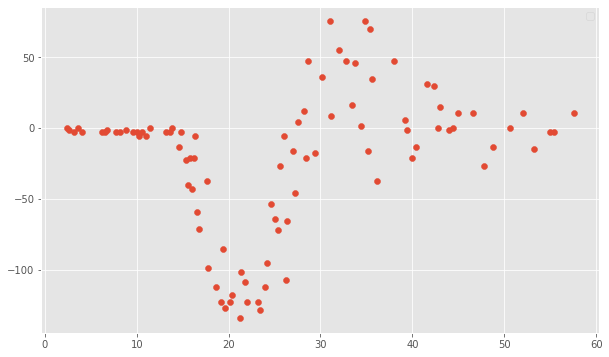

In [2]:
# Loading dataset

data = np.loadtxt('motor.dat')

X_data = data[:, 0][:, None]
y_data = data[:, 1][:, None]

X_data = np.float32(X_data)
y_data = np.float32(y_data)

print ('Loading',np.shape(X_data),np.shape(y_data))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(X_data,y_data)
ax.legend()
plt.show()

In [3]:
# Shuffling dataset

from sklearn.utils import shuffle

X_data_shuff,y_data_shuff = shuffle(X_data,y_data,random_state=23)
print ('Shuffling',np.shape(X_data_shuff),np.shape(y_data_shuff))

Shuffling (94, 1) (94, 1)


In [4]:
# Splitting dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data_shuff, y_data_shuff, test_size=0.2, random_state=23)
print ('Splitting',np.shape(X_train), np.shape(y_train))
print ('Splitting',np.shape(X_test), np.shape(y_test))

Splitting (75, 1) (75, 1)
Splitting (19, 1) (19, 1)


Scaling (75, 1) (75,)
Scaling (19, 1) (19,)
Scaled(train+test) (94, 1) (94,)


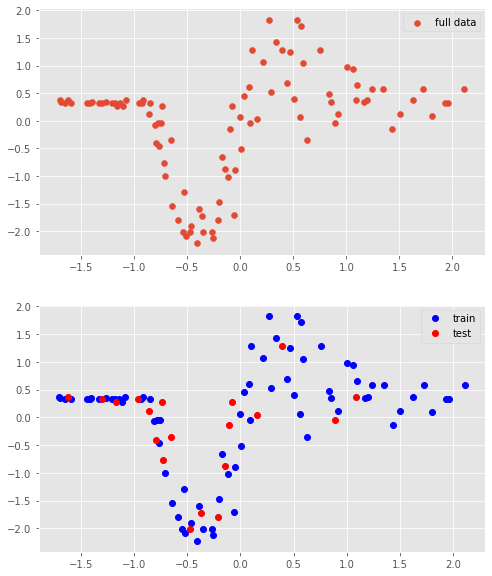

In [5]:
# Scaling dataset

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
scaler_y.fit(y_train)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

#combined data
X_data=np.vstack((X_train,X_test))
y_data=np.vstack((y_train,y_test))

y_train = y_train.ravel()
y_test = y_test.ravel()
y_data = y_data.ravel()

print ('Scaling',np.shape(X_train), np.shape(y_train))
print ('Scaling',np.shape(X_test), np.shape(y_test))

print ('Scaled(train+test)',np.shape(X_data),np.shape(y_data))

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.scatter(X_data,y_data,label='full data')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(X_train,y_train,'bo',label='train')
ax2.plot(X_test,y_test,'ro',label='test')
ax2.legend()
plt.show()

In [6]:
D = np.shape(X_train)[1]  # number of features or number of input neurons
H = 10
print (D,H) 

1 10


In [7]:
ed.set_seed(42)

Next, define a two-layer Bayesian neural network. Here, we define the neural network manually with `tanh` nonlinearities.

In [8]:
# Neural network number of neurons [D,H,H,1]
def neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

# prior
W_0 = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]),name="W_0")
W_1 = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]), name="W_1")
W_2 = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]), name="W_2")
b_0 = Normal(loc=tf.zeros(H), scale=tf.ones(H), name="b_0")
b_1 = Normal(loc=tf.zeros(H), scale=tf.ones(H), name="b_1")
b_2 = Normal(loc=tf.zeros(1), scale=tf.ones(1), name="b_2")

#likelihood
X = tf.placeholder(tf.float32, [None, D], name="X")
y = Normal(loc=neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2),
           scale=0.1 , name="y")

Next, make inferences about the model from data. We will use variational inference. Specify a normal approximation over the weights and biases.

q's are random variables defined to approximate the posterior [http://edwardlib.org/api/inference]

In [9]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, H]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, H])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [H, H]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [H, H])))
qW_2 = Normal(loc=tf.get_variable("qW_2/loc", [H, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_2/scale", [H, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [H]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [H])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [H]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [H])))
qb_2 = Normal(loc=tf.get_variable("qb_2/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_2/scale", [1])))

Defining `tf.get_variable` allows the variational factors’ parameters to vary. They are initialized randomly. The standard deviation parameters are constrained to be greater than zero according to a [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) transformation.

In [10]:
X_new = np.linspace(-2.5,2.5,100)[:,None]
X_new = np.float32(X_new)
print (X_new.shape)

(100, 1)


In [11]:
# Sample functions from variational model to visualize fits.
qW_0_s = qW_0.sample(1000)
qW_1_s = qW_1.sample(1000)
qW_2_s = qW_2.sample(1000)
qb_0_s = qb_0.sample(1000)
qb_1_s = qb_1.sample(1000)
qb_2_s = qb_2.sample(1000)
preds = tf.stack(
    [neural_network(X_new, qW_0_s[i], qW_1_s[i], qW_2_s[i],
                    qb_0_s[i], qb_1_s[i], qb_2_s[i])
     for i in range(1000)])

(1000, 100)
(100,)
(999, 100)


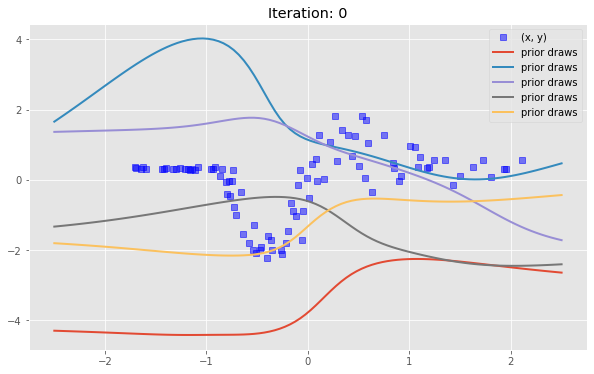

In [12]:
# FIRST VISUALIZATION (prior) #before optimization

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = preds.eval()

print(np.shape(outputs))
print(np.shape(outputs[0]))
print(np.shape(outputs[1:]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax.plot(X_new, outputs[0].T, lw=2, label='prior draws')
ax.plot(X_new, outputs[1:5].T, lw=2, label='prior draws')
ax.legend()
plt.show()

Now, run variational inference with the [Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) divergence in order to infer the model’s latent variables given data. We specify `1000` iterations.

In [13]:
N = X_train.shape[0]  # size of training data
M = 32  # batch size during training
print(N,M)

#ref: http://edwardlib.org/tutorials/batch-training
# We also define a helper function to select the "next" batch of data points from the full set of examples. 
# It keeps track of the current batch index and returns the next batch using the function next().
def generator(arrays, batch_size):
  """Generate batches, one with respect to each array's first axis."""
  starts = [0] * len(arrays)  # pointers to where we are in iteration
  while True:
    batches = []
    for i, array in enumerate(arrays):
      start = starts[i]
      stop = start + batch_size
      diff = stop - array.shape[0]
      if diff <= 0:
        batch = array[start:stop]
        starts[i] += batch_size
      else:
        batch = np.concatenate((array[start:], array[:diff]))
        starts[i] = diff
      batches.append(batch)
    yield batches

data = generator([X_train, y_train], M)
# We will generate batches from data during inference.

y_ph = tf.placeholder(tf.float32, [None])

n_batch = int(N / M)
n_epoch = 1500
n_iter = n_batch * n_epoch
print(n_batch,n_epoch,n_iter)

75 32
2 1500 3000


3000/3000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 420.994


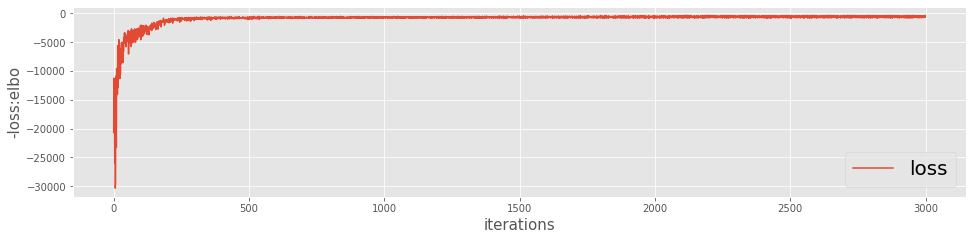

In [14]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data={y: y_ph})

#reference:
# http://edwardlib.org/tutorials/mixture-density-network
# http://edwardlib.org/api/inference
inference.initialize(n_iter=n_iter, n_samples=5, scale={y: N / M}) #(see below explanation)
LOSS = np.zeros(inference.n_iter)
tf.global_variables_initializer().run()
for i in range(inference.n_iter):
    X_batch, y_batch = next(data)
    info_dict = inference.update({X: X_batch, y_ph: y_batch})
    LOSS[i] = info_dict['loss']
    inference.print_progress(info_dict)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(inference.n_iter), -LOSS, label='loss')
plt.legend(fontsize=20)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('-loss:elbo', fontsize=15)
plt.show()    

# Explanation for scaling
# When initializing inference, note we scale y by N/M, so it is as if the 
# algorithm had seen N/M as many data points per iteration. 
# Algorithmically, this will scale all computation regarding y by N/M
# such as scaling the log-likelihood in a variational method’s objective. 
# (Statistically, this avoids inference being dominated by the prior.)

In [15]:
# print(help(inference))

Finally, criticize the model fit. Bayesian neural networks define a distribution over neural networks, so we can perform a graphical check. Draw neural networks from the inferred model and visualize how well it fits the data.

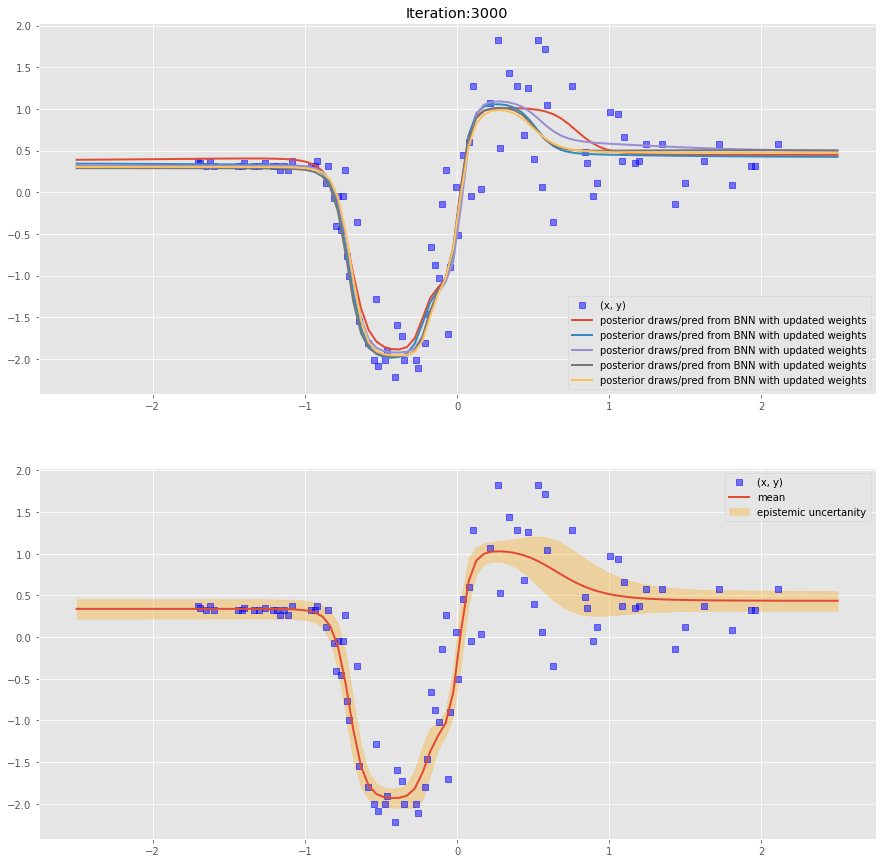

In [16]:
# SECOND VISUALIZATION (posterior) #after optimization

outputs = preds.eval()

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title("Iteration:"+str(inference.n_iter))
ax1.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_new, outputs[0].T, lw=2, label='posterior draws/pred from BNN with updated weights')
ax1.plot(X_new, outputs[1:5].T, lw=2, label='posterior draws/pred from BNN with updated weights')
ax1.legend()


mean_pred = np.mean(outputs, axis=0)
std_pred = np.std(outputs, axis=0)
ax2 = fig.add_subplot(212)
ax2.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot(X_new, mean_pred , lw=2,label='mean')
ax2.fill_between(X_new.ravel(), mean_pred-2*std_pred, mean_pred+2*std_pred, alpha = 0.3, color = 'orange',label='epistemic uncertanity')
ax2.legend()

plt.show()

The model has captured the relationship between $x$ and $y$ in the observed domain.

## Testing on whole data

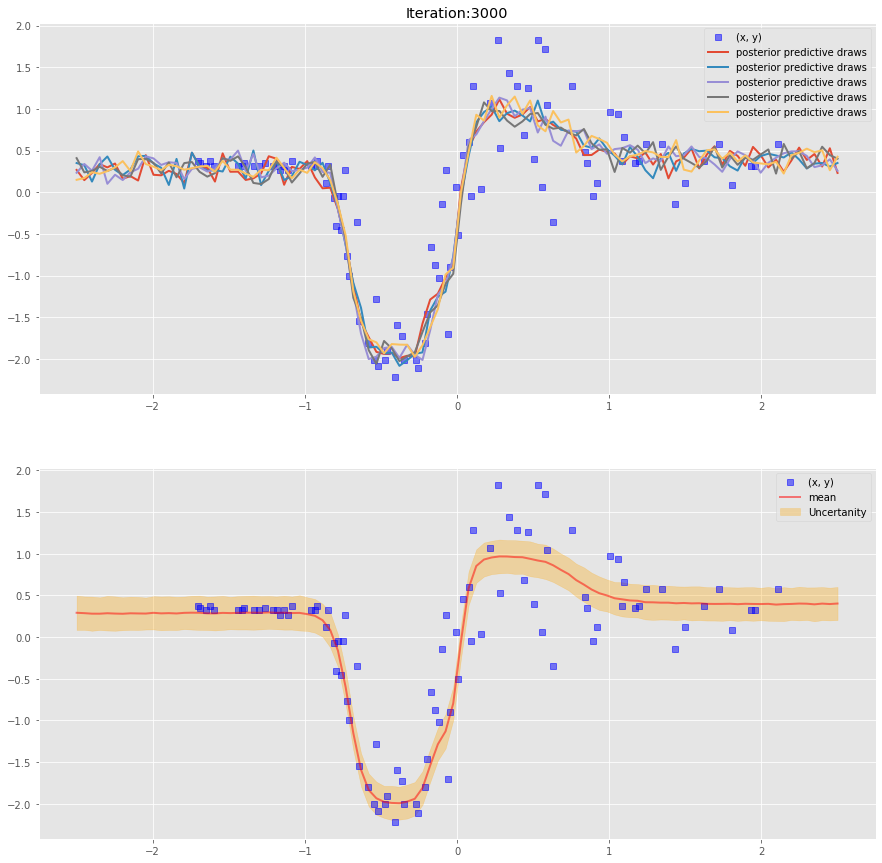

In [17]:
# THIRD VISUALIZATION (posterior predictive) 

# preds_lik = tf.stack(
#     [ Normal( loc=neural_network(X_new, qW_0_s[i], qW_1_s[i], qW_2_s[i],
#                     qb_0_s[i], qb_1_s[i], qb_2_s[i]),scale=0.1 ).sample() 
#      for i in range(1000)])
# outputs_lik = preds_lik.eval()

# or 
# (ref:http://edwardlib.org/tutorials/batch-training)
y_post = ed.copy(y, {W_0: qW_0, W_1: qW_1, W_2: qW_2, b_0: qb_0, b_1: qb_1, b_2: qb_2})
# This is equivalent to
# y_post = Normal( loc=neural_network(X, qW_0, qW_1, qW_2,
#                     qb_0, qb_1, qb_2),scale=0.1 )
preds_lik = tf.stack(
    [ y_post.sample() 
     for _ in range(1000)])
outputs_lik = preds_lik.eval(feed_dict={X:X_new})


fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title("Iteration:"+str(inference.n_iter))
ax1.plot(X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax1.plot(X_new, outputs_lik[0].T, lw=2, label='posterior predictive draws')
ax1.plot(X_new, outputs_lik[1:5].T, lw=2, label='posterior predictive draws')
ax1.legend()

mean_pred_lik = np.mean(outputs_lik, axis=0)
std_pred_lik = np.std(outputs_lik, axis=0)
ax2 = fig.add_subplot(212)
ax2.plot( X_data, y_data, 'bs', alpha=0.5, label='(x, y)') # full data (train+test)
ax2.plot( X_new, mean_pred_lik , 'r', lw=2, alpha=0.5, label='mean')
ax2.fill_between(X_new.ravel(), mean_pred_lik-2*std_pred_lik, mean_pred_lik+2*std_pred_lik, alpha = 0.3, color = 'orange',label='Uncertanity')
ax2.legend()

plt.show()

(1000, 1, 10)


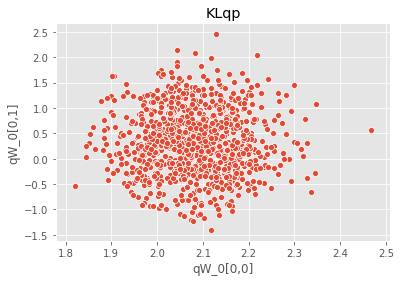

In [18]:
check = qW_0.sample(1000).eval()
print(check.shape)
param_samples_KLqp = pd.DataFrame(
    {'qW_0[0,0]': check.reshape(check.shape[0],check.shape[2])[:,0], 
     'qW_0[0,1]': check.reshape(check.shape[0],check.shape[2])[:,1]})

_ = sns.scatterplot(x='qW_0[0,0]', y='qW_0[0,1]', data=param_samples_KLqp).set_title('KLqp')

## Testing on only test data 

        KLqp    actual  error_KLqp
0   0.024441 -0.403941    0.428382
1  -1.934154 -1.723242   -0.210912
2  -1.395023 -0.351711   -1.043313
3   0.336965  0.373712   -0.036746
4   0.343595  0.269251    0.074344
5  -1.085338 -0.144723   -0.940615
6   0.529754  0.373712    0.156042
7   0.954472  0.037116    0.917356
8  -0.591241 -0.767619    0.176378
9   0.342072  0.321481    0.020591
10  1.059924  1.280973   -0.221049
11 -1.182796 -0.872080   -0.310716
12  0.776961 -0.042197    0.819158
13 -1.425818 -1.802555    0.376738
14 -1.963272 -2.007608    0.044335
15  0.251240  0.116429    0.134812
16  0.325410  0.321481    0.003929
17 -0.436193  0.269251   -0.705444
18 -1.004444  0.269251   -1.273695


/Users/sharmila/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


RMSE for KLqp test predictions = 0.571


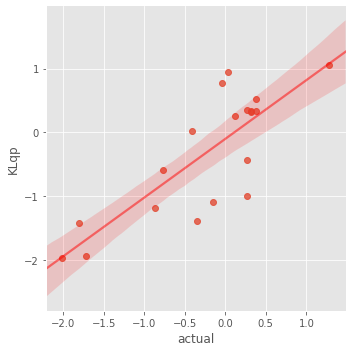

In [19]:
y_post = ed.copy(y, {W_0: qW_0, W_1: qW_1, W_2: qW_2, b_0: qb_0, b_1: qb_1, b_2: qb_2})
# This is equivalent to
# y_post = Normal( loc=neural_network(X, qW_0, qW_1, qW_2,
#                     qb_0, qb_1, qb_2),scale=0.1 )
preds_lik = tf.stack(
    [ y_post.sample() 
     for _ in range(1000)])
outputs_lik_test = preds_lik.eval(feed_dict={X:X_test})
mean_pred_lik_test = np.mean(outputs_lik_test, axis=0)
std_pred_lik_test = np.std(outputs_lik_test, axis=0)

prediction_data_test = pd.DataFrame(
    {'KLqp': mean_pred_lik_test.flatten(), 
     'actual': y_test.flatten(),
     'error_KLqp': ( mean_pred_lik_test - y_test).flatten()})

print (prediction_data_test)

_ = sns.lmplot(y='KLqp', x='actual', data=prediction_data_test,
               line_kws={'color': 'red', 'alpha': 0.5})

RMSE = np.sqrt(np.mean(prediction_data_test.error_KLqp ** 2))
print(f'RMSE for KLqp test predictions = {RMSE:.3f}')

In [20]:
# print (y_post)
# print(W_0)

In [21]:
# https://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/batch_training.ipynb
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}, n_samples=500))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}, n_samples=500))

Mean squared error on test data:


/Users/sharmila/anaconda3/envs/py36/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


0.3196375
Mean absolute error on test data:
0.40091157


In [22]:
print(qW_0.loc,qW_0.loc.eval())
print(qW_0.scale,qW_0.scale.eval())

Tensor("Normal/loc:0", shape=(1, 10), dtype=float32) [[ 2.083591    0.28965548  1.2190989  -0.12753929 -2.3701081   0.97145283
  -1.2859579  -0.35668698  0.87559056 -3.5258553 ]]
Tensor("Normal/scale:0", shape=(1, 10), dtype=float32) [[0.0879813  0.6155385  0.18212748 0.3060851  0.01899458 0.17764173
  0.20984222 0.4276859  0.24490619 0.25765917]]


In [23]:
print(W_0.loc,W_0.loc.eval())
print(W_0.scale,W_0.scale.eval())

Tensor("W_0/loc:0", shape=(1, 10), dtype=float32) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Tensor("W_0/scale:0", shape=(1, 10), dtype=float32) [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
